# Introduction to Linear Regression Analysis

This section is just importing the packages used in the code. `% matplotlib inline` is specifically for Jupyter Notebooks, and just makes visualization of plots nicer in this format. The warning filters just ignore warning messages that don't apply these situations. Normally I would not ignore these until after verifying that they don't effect the data at all.

These package abbreviations will be used throughout the file, but the most notable ones are:

`pandas` - this is a library that is used to manipulate dataframes. Dataframes are basically the same as tables that you would use in excel, and the visual representations can be seen in all the tables in this file.

`seaborn` - this is the plotting library that I use. It extends the basic capabilities of matplotlib (which is the standard Python plotting library) with specific plots and color schemes.

`numpy` - generally used for array math and general math functions that don't exist natively in Python3, like square root.

In [83]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# for jupyter plot visualization
% matplotlib inline
# filtering out warnings 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="sklearn", message="^max_iter")
warnings.filterwarnings(action="ignore", module="sklearn", message="^Maximum")

This cell imports the raw data, and splits it into two dataframes, `stats_df` and `df`. Pandas `read_csv` basically just converts a .csv file into a pandas dataframe, much like if you were to open a .csv in Excel. 

I split the data into two dataframes in order to be able to calculate the summary statistics. Since it doesn't make sense to get the mean, median, mode, etc. of the cities, states, and zipcode, I dropped them from the dataframe that is going to be used for summary statistics.

In [ ]:
# data import
df = pd.read_csv('2017-11-21_230246.csv')
stats_df = df.drop(['city', 'state', 'zip'], 1)
stats_df = stats_df.dropna()
df = df.dropna()
df = df.drop('state', 1)

## Summary Statistics

This generates the summary statistics dataframe (table). Pandas `concat` function just joins dataframes together along the `1` axis, which is columns (axis 0 are rows of a dataframe). Luckily, the `describe()` method already does most of this, and generated the first 8 columns. The `.T` at the end is a transpose, because natively `describe()` has the summary statistics as rows and the features as columns. The median, mode, and variance were taken manually, using the `.median()`, `.mode()`, and `.var()` methods, and then joined to the `describe()` results. 

After that, I renamed the columns, since `.median()`, `.mode()`, and `.var()` methods produce columns without names.

The last line is just for displaying the dataframe in the `Out`.

In [84]:
summary_df = pd.concat([stats_df.describe().T, stats_df.median(), stats_df.mode().iloc[0], stats_df.var()], axis=1)
summary_df.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Median', 'Mode', 'Variance']
summary_df

,Count,Mean,Std,Min,25%,50%,75%,Max,Median,Mode,Variance
price,3854.0,2.904184e+06,6.325874e+06,9900.00,655000.00,1300000.0,2799749.25,180000000.0,1300000.0,799000.0,4.001669e+13
sqft,3854.0,2.869577e+03,2.740097e+03,110.00,1367.25,2072.0,3500.00,51000.0,2072.0,1200.0,7.508132e+06
bedrooms,3854.0,3.774520e+00,2.428690e+00,0.00,2.00,3.0,4.00,48.0,3.0,3.0,5.898536e+00
bathrooms,3854.0,3.503762e+00,2.725417e+00,0.75,2.00,3.0,4.00,48.0,3.0,2.0,7.427899e+00


## Finding Outliers Outside of 3 Standard Deviations, and Noting it

This code snippet is a loop of the columns in the dataframe used for the summary statistics above, which does the following for each feature:

1. Calculates the upper and lower standard deviation bounds for that feature, using 3 times the standard deviation.
2. Gets the rows of that feature that are either above the upper standard deviation bound or below the lower standard deviation bound (these are the rows that are outliers).
3. Adds the index of the outlier rows to a list, `outlier_index`.

After the loop, `set()` takes the outlier list and removes duplicate indices that were found when looking at houses that were an outlier in multiple categories. Ex: a $90 million home with 20 bedrooms, 20 bathrooms, and that is 31000 sqft is likely an outlier in all of those categories, the dataframe index of that home would be in the `outlier_index` list 4 times.

In [122]:
outlier_index = []
for col in stats_df:
    upper_standard_dev_3 = stats_df[col].std() * 3
    lower_standard_dev_3 = -upper_standard_dev_3
    outlier_index.extend(stats_df.index[(stats_df[col] > upper_standard_dev_3) | (stats_df[col] < lower_standard_dev_3)].tolist())
outlier_index = set(outlier_index)

This snippet just creates a list of `True` or `False` values for all the rows in the dataframe. When a row that is in the `outlier_index` list is found, it returns `True`, otherwise it returns `False`. Since each row is either in the list or it isn't, this list is about 3200 items long.

In [127]:
outlier_bool_df = stats_df.index.isin(outlier_index)

This filters the full dataframe: it creates two dataframes, that is only the outliers detected above `outlier_df`, and one without the outliers, `df_sans_outliers`. It then saves the outliers in the `outliers.csv` file, and prints the list of outliers to `Out`. Note: the printed list is truncated, because it's 299 items long. The entirety of the data is in `outliers.csv`.

In [128]:
df_sans_outliers = stats_df[~outlier_bool_df]
outlier_df = stats_df[outlier_bool_df]
outlier_df.to_csv('outliers.csv', index=False)
outlier_df

,price,sqft,bedrooms,bathrooms
208,699000.0,3695.0,8.0,6.00
226,699900.0,4740.0,16.0,8.00
232,690000.0,2655.0,8.0,4.00
233,719900.0,3636.0,8.0,4.00
273,555000.0,2848.0,8.0,4.00
285,625000.0,2690.0,8.0,4.00
379,2100000.0,7638.0,8.0,14.00
386,2050000.0,6709.0,13.0,13.00
387,2020000.0,4888.0,8.0,4.00
392,2125000.0,7836.0,12.0,12.00


## Scatter Plot Matrix

This scatter plot matrix is created with seaborn. It kinda just works out of the box on the dataframe that was just built, and whose outliers were removed. The `size` parameter is the size of the image, the `subplots_adjust` function shifts the plots down so they don't overlap with the title, and the `fig.suptitle` method sets the title text and size. `plt.show()` is used to display the plots.

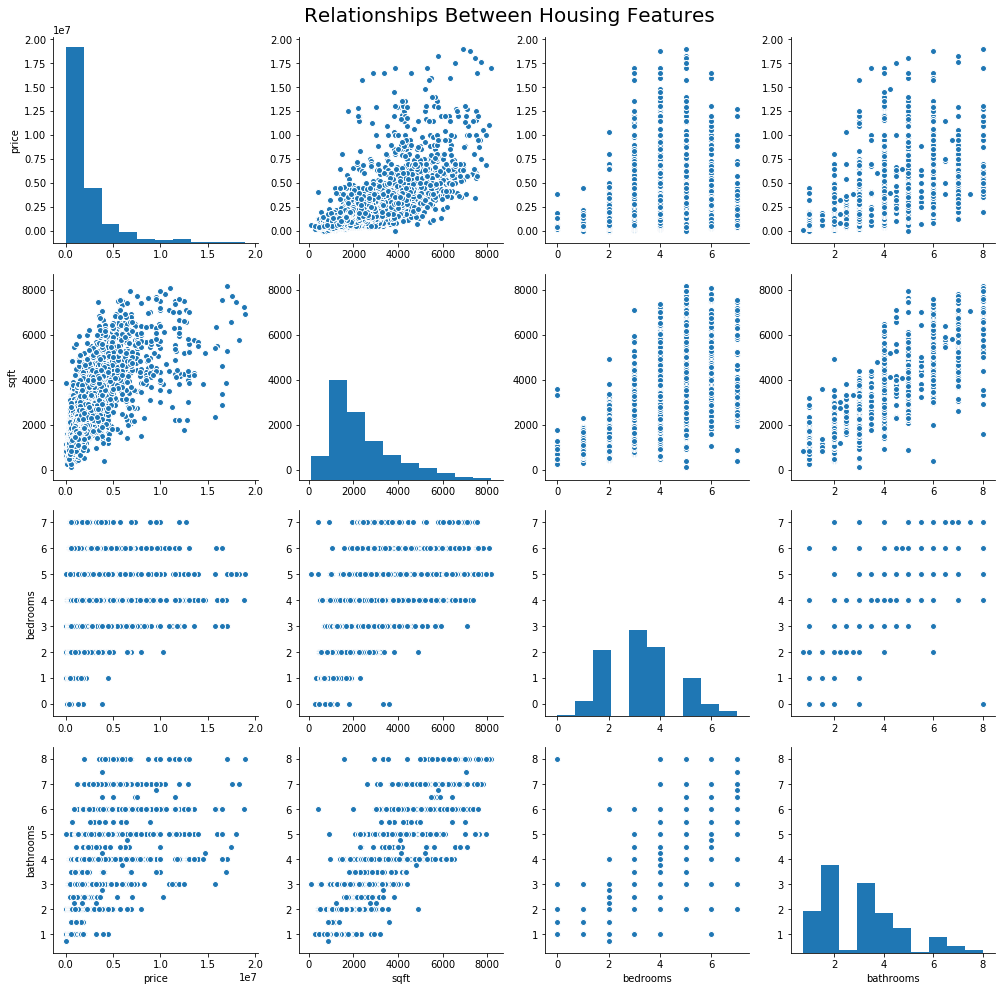

In [129]:
g = sns.pairplot(df_sans_outliers, size=3.5)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Relationships Between Housing Features', size=20)
plt.show()

## Correlation Mapping

Similar to the scatterplot matrix, a heatmap is used to display the correlation. The first line establishes a blank plotting slate for the seaborn library to plot upon. This is only necessary for resizing. 

After creating the blank slate, a second blank slate is created for the colorbar of the heatmap, whose purpose is just to provide a key to the color scale. The numbers provided are just cordinates of the slate, in pixels. I honestly just messed with them until it looked like the colorbar was in the right position.

The heatmap method has a few quirks: 
1. Heatmaps plot correlation matrices, so rather than just plotting the raw dataframe, we need to plot `dataframe.corr()`, which produces a correlation matrix of the data.
2. `annot=True` prints the correlation numbers on the plot.
3. `square=True` just makes it so the colored boxes are square rather than rectangular.
4. `cbar_ax=cbar_ax` assigns the colorbar to the colorbar axis just created. This is just to resize the colorbar so it looks nice.
4. `ax=ax` tells the `heatmap()` method to use the blank slate created on the first line as the grid to draw the plot on.

The same title and plot adjustment were done with the heatmap as well.

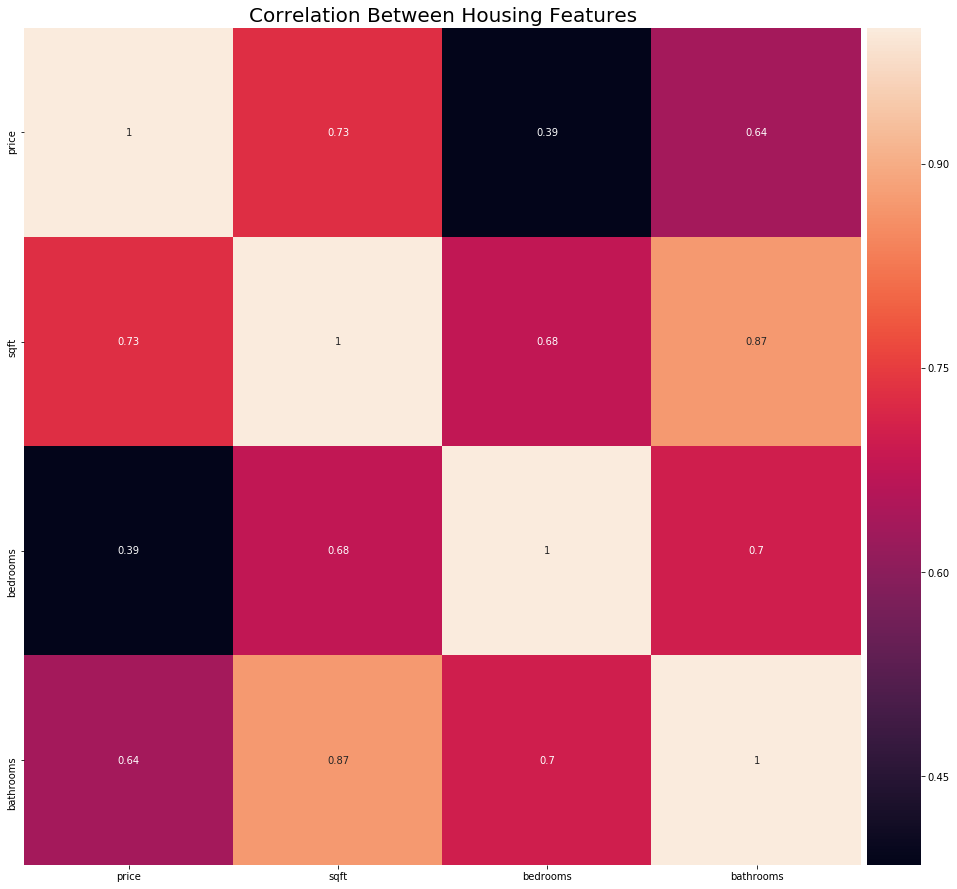

In [153]:
fig, ax = plt.subplots(figsize=(15,15))
cbar_ax = fig.add_axes([.905, .15, .05, .775])
sns.heatmap(df_sans_outliers.corr(), annot=True, square=True, cbar_ax=cbar_ax, ax=ax).set_title('Correlation Between Housing Features', size=20)
plt.subplots_adjust(top=0.95)
plt.show()

## Correlation Coefficients Ranked

First, I wanted to create a copy of the dataframe that didn't contain outliers, since there had been some manipulation done on it, so if I accidentally deleted all the rows for some reason, I could come back to this point in the code and create another copy, rather than going back to the beginning and reimporting the raw data.

Then, similarly to above, we needed to create a correlation matrix to rank the correlations of the features to the price. To do that, I chained together a few different methods, which are, in order:
1. `corr()` creates the correlation matrix
2. `['price']` since we are only interested in the correlation of features to the price of a house, we filter the correlation matrix by price.
3. `sort_values(ascending=False)` sorts the correlations of the features, and ranks them highest to lowest.
4. `.iloc[1:]` originally, this would also contain the price feature, but since the correlation between price and price is 1, and it is the independent variable, we aren't interested in it. `iloc[]` filters dataframe rows or columns or both, with the same syntax as any other Python list slicing, with the rows being the first slice and the columns being the second. It's a very important function for dataframe manipulation, so I'll give a few examples.

`iloc` Examples:
1. `dataframe.iloc[:, :]` returns all the rows and all the columns
2. `dataframe.iloc[1:, :]` returns all the rows except the first row and all the columns
3. `dataframe.iloc[:, 1:]` returns all the rows and all the columns except the first column
4. `dataframe.iloc[1:]` returns all the rows except the first row and all the columns (if not specified, the columns slice defaults to all columns)
5. `dataframe.iloc[:1, :]` returns all the rows except the last row and all the columns
6. `dataframe.iloc[1]` returns only row 1 (which is the second row, because of 0-based indexing) and all the columns

In [131]:
# subtracting the outliers from the training dataset
training_df = df_sans_outliers.copy()
training_df.corr()['price'].sort_values(ascending=False).iloc[1:]

sqft         0.729050
bathrooms    0.636941
bedrooms     0.385059
Name: price, dtype: float64

## ML and Model Optimization

These are just some more imports specific to machine leaning from the scikit-learn library.

In [89]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

Here, we split the training dataframe into the independent variable (price), which is generally denoted `y`, and the dependent variables (sqft, bathrooms, bedrooms), which is generally denoted `X`.

In [ ]:
# defining the independent and dependent variables
X = training_df.drop('price', 1)
y = training_df['price']

In preparation for the optimization, we build some parameter grids for the Stochastic Gradient Descent and Linear Regression models. The purpose of this is to give the `GridSearchCV` method some model parameters to search through. Since `GridSearchCV` is a brute force search, it tests all combinations of all parameters that are fed to it. To find which parameters to use, I usually visit the page of the model, unless I'm extremely familiar with it. This is generally a good idea to do even if you are really familiar with a model, as there are always tweaks or changes to functionality that the scikit-learn team introduces over time. 

Linear Regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Stochastic Gradient Descent Regressor: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

The `scoring` parameter indicates that we want `GridSearchCV` to rank the models tested by MSE, so we can just pull the best model from the search, and use that for fitting the data.

In [ ]:
# creating grid search cv parameters for brute force parameter searching
sgd = GridSearchCV(SGDRegressor(), param_grid={
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'max_iter': [1000],
    'tol': [1e-3]
}, return_train_score=True, scoring='neg_mean_squared_error')

lr = GridSearchCV(LinearRegression(), param_grid={
    'fit_intercept': [True, False],
    'normalize': [True, False]
}, return_train_score=True, scoring='neg_mean_squared_error')

This splits the training data into the 3 most important features, 2 most important features, and 1 most important feature. The `values.reshape(-1, 1)` methods are because fitting models with only one feature is generally frowned upon, so it gives the data a second dummy feature of all zeros, just so it scikit-learn will accept the data as valid, an dprocede with fitting.

In [ ]:
# Manually selecting most important features
three_feature_df = X[['sqft', 'bedrooms', 'bathrooms']]
two_feature_df = X[['sqft', 'bathrooms']]
one_feature_df = X['sqft'].values.reshape(-1, 1)

This is where the model fitting happens. There's quite a bit going on here, but unfortunately I can't part it out because it's in a loop, so I'll just call out line numbers.

In [161]:
# Iterating through the dataframes containing 1, 2, and 3 features
MSE_ranking_dict = {}
for x, name in zip([three_feature_df, two_feature_df, one_feature_df], ['three', 'two', 'one']):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
    
    # fitting the GridSearchCV pipelines
    lr.fit(x, y)
    sgd.fit(x, y)
    
    # fitting the best estimators of each grid search
    lr.best_estimator_.fit(X_train, y_train)
    sgd.best_estimator_.fit(X_train, y_train)
    
    # assigning keys and values for display  
    lr_key = f"Linear Regression MSE using {name} features"
    lr_value = mean_squared_error(y_test, lr.best_estimator_.predict(X_test))
    lr_coefs = [y for y in lr.best_estimator_.coef_]
    if len(lr_coefs) < 6:
        if name == 'three':
            lr_coefs = [0] * (3 - len(lr_coefs)) + lr_coefs
        elif name == 'two':
            lr_coefs = [0] * (2 - len(lr_coefs)) + [lr_coefs[0]] + [0] + [lr_coefs[1]]
        elif name == 'one':
            lr_coefs = [0] * (1 - len(lr_coefs)) + lr_coefs + [0] * 2
    sgd_key = f"Stochastic Gradient Descent MSE using {name} features"
    sgd_value = mean_squared_error(y_test, sgd.best_estimator_.predict(X_test))
    sgd_coefs = [y for y in sgd.best_estimator_.coef_]
    if len(sgd_coefs) < 6:
        if name == 'three':
            sgd_coefs = [0] * (3 - len(sgd_coefs)) + sgd_coefs
        elif name == 'two':
            sgd_coefs = [0] * (2 - len(sgd_coefs)) + [sgd_coefs[0]] + [0] + [sgd_coefs[1]]
        elif name == 'one':
            sgd_coefs = [0] * (1 - len(sgd_coefs)) + sgd_coefs + [0] * 2
    MSE_ranking_dict[sgd_key] = [sgd_value] + sgd_coefs + [sgd.best_estimator_.intercept_[0]]
    MSE_ranking_dict[lr_key] = [lr_value] + lr_coefs + [lr.best_estimator_.intercept_]

In [162]:
# displaying and sorting the MSEs of each model/feature combination
MSE_diplay_df = pd.DataFrame.from_dict(MSE_ranking_dict, orient='index')
MSE_diplay_df.columns = ['MSE'] + [f"{x.capitalize()} Coefficient" for x in list(X.columns)] + ['Intercept']
MSE_diplay_df.sort_values('MSE')

,MSE,Sqft Coefficient,Bedrooms Coefficient,Bathrooms Coefficient,Intercept
Linear Regression MSE using three features,2.159930e+12,1329.032121,-478781.881023,184887.903543,0.000000
Linear Regression MSE using one features,2.289238e+12,1245.575063,0.000000,0.000000,-867145.128313
Linear Regression MSE using two features,2.300640e+12,1208.893497,0.000000,39181.022735,-897833.947720
Stochastic Gradient Descent MSE using two features,2.677352e+12,762.546797,0.000000,-0.105979,-2.043674
Stochastic Gradient Descent MSE using three features,2.708709e+12,749.820436,-5.575088,0.009364,-1.972151
Stochastic Gradient Descent MSE using one features,2.840274e+12,704.121739,0.000000,0.000000,-2.606469


## Normalized Root Mean Squared Error

In [163]:
pd.Series(np.sqrt(MSE_diplay_df['MSE'])/y_train.mean()).sort_values()

Linear Regression MSE using three features              0.685786
Linear Regression MSE using one features                0.706016
Linear Regression MSE using two features                0.707772
Stochastic Gradient Descent MSE using two features      0.763522
Stochastic Gradient Descent MSE using three features    0.767980
Stochastic Gradient Descent MSE using one features      0.786410
Name: MSE, dtype: float64